In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.inspection import permutation_importance
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.model_selection import cross_val_score
from scipy.stats import spearmanr
from scipy.cluster import hierarchy
import pingouin as pg
import seaborn as sns

In [2]:
df = pd.read_csv('allTogether.csv')

# remove ids and numbers
df = df.drop(['_id','question.number','user._id'], axis=1)
# groupNames, majLabel and colors are synonyms
df = df.drop(['question.groupNames','question.colors'], axis=1)

# add absolute version of the cv score (demographic parity)
df['question.abs_cv'] = df['question.cv']
df.loc[df['question.cv']>1, 'question.abs_cv'] = 2-df['question.cv']
# add absolute version of the rND score (demographic parity)
df['question.abs_rND'] = df['question.new_rND']
df.loc[df['question.new_rND']>1, 'question.abs_rND'] = 2-df['question.new_rND']
# add absolute versions of comparative accuracy scores
df['question.abs_s_tnr'] = df['question.s_tnr']
df.loc[df['question.s_tnr']>1, 'question.abs_s_tnr'] = 2-df['question.s_tnr']
df['question.abs_s_tpr'] = df['question.s_tpr']
df.loc[df['question.s_tpr']>1, 'question.abs_s_tpr'] = 2-df['question.s_tpr']
df['question.abs_s_bcr'] = df['question.s_bcr']
df.loc[df['question.s_bcr']>1, 'question.abs_s_bcr'] = 2-df['question.s_bcr']
# add absolute versions of comparative adjusted accuracy scores
df['question.abs_s_adj_tnr'] = df['question.s_adj_tnr']
df.loc[df['question.s_adj_tnr']>1, 'question.abs_s_adj_tnr'] = 2-df['question.s_adj_tnr']
df['question.abs_s_adj_tpr'] = df['question.s_adj_tpr']
df.loc[df['question.s_adj_tpr']>1, 'question.abs_s_adj_tpr'] = 2-df['question.s_adj_tpr']
df['question.abs_s_adj_bcr'] = df['question.s_adj_bcr']
df.loc[df['question.s_adj_bcr']>1, 'question.abs_s_adj_bcr'] = 2-df['question.s_adj_bcr']
pd.set_option('display.max_columns', None)
df.head()

,rating,inconfidence,secondsElapsed,question.questionType,question.minSize,question.majSize,question.majLabel,question.tpr,question.tnr,question.bcr,question.accuracy,question.adj_tpr,question.adj_tnr,question.adj_bcr,question.adj_accuracy,question.tpr0,question.tnr0,question.bcr0,question.accuracy0,question.adj_tpr0,question.adj_tnr0,question.adj_bcr0,question.adj_accuracy0,question.tpr1,question.tnr1,question.bcr1,question.accuracy1,question.adj_tpr1,question.adj_tnr1,question.adj_bcr1,question.adj_accuracy1,question.s_tpr,question.s_tnr,question.s_bcr,question.s_accuracy,question.s_adj_tpr,question.s_adj_tnr,question.s_adj_bcr,question.s_adj_accuracy,question.cv,question.cluster,question.ordering_utility,question.sum_of_diff,question.rND,question.new_rND,user.language,user.accuracy,user.age,user.believe,user.comparativeAccuracy,user.confidence,user.edu,user.fear,user.gender,user.genderParity,user.political,user.religious,user.screenHeight,user.screenWidth,user.will,user.agreeableness,user.conscientiousness,user.extraversion,user.neuroticism,user.openness,question.abs_cv,question.abs_rND,question.abs_s_tnr,question.abs_s_tpr,question.abs_s_bcr,question.abs_s_adj_tnr,question.abs_s_adj_tpr,question.abs_s_adj_bcr
0,0.89,0.84,36.534,selection,3,7,female,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,NaN,NaN,1.00,1.000000,NaN,NaN,1.000000,1.0,1.0,1.00,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,NaN,NaN,1.000000,1.000000,NaN,NaN,1.000000,1.714286,3,NaN,NaN,NaN,NaN,de,0.86,25,0.37,0.34,0.74,abitur,0.5,male,0.73,0.78,0.13,1080,1920,0.82,3.0,1.5,3.5,2.5,4.0,0.285714,NaN,NaN,1.000000,NaN,NaN,1.000000,NaN
1,0.58,NaN,16.849,selection,5,5,female,0.833333,0.750000,0.791667,0.8,0.927083,0.833333,0.880208,0.898551,0.666667,1.000000,0.833333,0.80,0.854167,1.000000,0.927083,0.898551,1.0,0.5,0.75,0.800000,1.000000,0.666667,0.833333,0.898551,0.666667,1.500000,1.083333,1.000000,0.854167,1.333333,1.093750,1.000000,0.600000,8,NaN,NaN,NaN,NaN,de,0.86,25,0.37,0.34,0.74,abitur,0.5,male,0.73,0.78,0.13,1080,1920,0.82,3.0,1.5,3.5,2.5,4.0,0.600000,NaN,0.500000,0.666667,0.916667,0.666667,0.854167,0.906250
2,0.39,0.06,12.849,selection,4,6,male,0.666667,0.857143,0.761905,0.8,0.774194,0.885246,0.829720,0.862745,1.000000,0.666667,0.833333,0.75,1.000000,0.791045,0.895522,0.827160,0.5,1.0,0.75,0.833333,0.730769,1.000000,0.865385,0.921348,1.500000,0.666667,1.083333,0.916667,1.269231,0.791045,1.030138,0.905812,1.333333,7,NaN,NaN,NaN,NaN,de,0.86,25,0.37,0.34,0.74,abitur,0.5,male,0.73,0.78,0.13,1080,1920,0.82,3.0,1.5,3.5,2.5,4.0,0.666667,NaN,0.666667,0.500000,0.916667,0.791045,0.730769,0.969862
3,0.25,NaN,10.424,selection,4,6,female,0.500000,0.666667,0.583333,0.6,0.565217,0.813725,0.689471,0.736486,0.333333,1.000000,0.666667,0.50,0.395349,1.000000,0.697674,0.500000,1.0,0.6,0.80,0.666667,1.000000,0.747967,0.873984,0.770370,0.333333,1.400000,0.866667,0.833333,0.395349,1.252033,0.823691,0.729630,0.750000,2,NaN,NaN,NaN,NaN,de,0.86,25,0.37,0.34,0.74,abitur,0.5,male,0.73,0.78,0.13,1080,1920,0.82,3.0,1.5,3.5,2.5,4.0,0.750000,NaN,0.600000,0.333333,0.866667,0.747967,0.395349,0.823691
4,0.05,0.13,8.199,selection,1,9,female,0.000000,0.888889,0.444444,0.8,0.000000,0.857143,0.428571,0.825911,NaN,0.000000,NaN,0.00,NaN,0.000000,NaN,0.000000,0.0,1.0,0.50,0.888889,0.000000,1.000000,0.500000,0.957746,NaN,0.000000,NaN,0.111111,NaN,0.000000,NaN,0.042254,2.000000,0,NaN,NaN,NaN,NaN,de,0.86,25,0.37,0.34,0.74,abitur,0.5,male,0.73,0.78,0.13,1080,1920,0.82,3.0,1.5,3.5,2.5,4.0,0.000000,NaN,0.000000,NaN,NaN,0.000000,NaN,NaN


In [3]:
cat_cols = [
    'question.majLabel',
    'question.questionType',
    'user.language',
    'user.age',
    'user.edu',
    'user.gender',
]
num_cols = [
    'secondsElapsed',
    'question.minSize',
    'question.majSize',
    'user.believe',
    'user.confidence',
    'user.fear',
    'user.political',
    'user.religious',
    'user.screenHeight',
    'user.screenWidth',
    'user.will',
    'user.agreeableness',
    'user.conscientiousness',
    'user.extraversion',
    'user.neuroticism',
    'user.openness',
]
num_cols_sel = [
    'question.tpr',
    'question.tnr',
    'question.bcr',
    'question.accuracy',
    'question.adj_tpr',
    'question.adj_tnr',
    'question.adj_bcr',
    'question.adj_accuracy',
    'question.tpr0',
    'question.tnr0',
    'question.bcr0',
    'question.accuracy0',
    'question.adj_tpr0',
    'question.adj_tnr0',
    'question.adj_bcr0',
    'question.adj_accuracy0',
    'question.tpr1',
    'question.tnr1',
    'question.bcr1',
    'question.accuracy1',
    'question.adj_tpr1',
    'question.adj_tnr1',
    'question.adj_bcr1',
    'question.adj_accuracy1',
    'question.s_tpr',
    'question.s_tnr',
    'question.s_bcr',
    'question.s_accuracy',
    'question.s_adj_tpr',
    'question.s_adj_tnr',
    'question.s_adj_bcr',
    'question.s_adj_accuracy',
    'question.abs_s_tpr',
    'question.abs_s_tnr',
    'question.abs_s_bcr',
    'question.abs_s_adj_tpr',
    'question.abs_s_adj_tnr',
    'question.abs_s_adj_bcr',
    'question.cv',
    'question.abs_cv',
]
num_cols_ran = [
    'question.ordering_utility',
    'question.sum_of_diff',
    'question.new_rND',
    'question.abs_rND'
]
# don't use the following attributes in the model
    #'inconfidence',
    #'question.cluster',
    #'user.accuracy',
    #'user.comparativeAccuracy',
    #'user.genderParity',

# split dataset according to questionType
df_ran = df.query("`question.questionType` == 'ranking'")[['rating'] + num_cols + num_cols_ran + cat_cols]
df_sel = df.query("`question.questionType` == 'selection'")[['rating'] + num_cols + num_cols_sel + cat_cols]
df_sel

,rating,secondsElapsed,question.minSize,question.majSize,user.believe,user.confidence,user.fear,user.political,user.religious,user.screenHeight,user.screenWidth,user.will,user.agreeableness,user.conscientiousness,user.extraversion,user.neuroticism,user.openness,question.tpr,question.tnr,question.bcr,question.accuracy,question.adj_tpr,question.adj_tnr,question.adj_bcr,question.adj_accuracy,question.tpr0,question.tnr0,question.bcr0,question.accuracy0,question.adj_tpr0,question.adj_tnr0,question.adj_bcr0,question.adj_accuracy0,question.tpr1,question.tnr1,question.bcr1,question.accuracy1,question.adj_tpr1,question.adj_tnr1,question.adj_bcr1,question.adj_accuracy1,question.s_tpr,question.s_tnr,question.s_bcr,question.s_accuracy,question.s_adj_tpr,question.s_adj_tnr,question.s_adj_bcr,question.s_adj_accuracy,question.abs_s_tpr,question.abs_s_tnr,question.abs_s_bcr,question.abs_s_adj_tpr,question.abs_s_adj_tnr,question.abs_s_adj_bcr,question.cv,question.abs_cv,question.majLabel,question.questionType,user.language,user.age,user.edu,user.gender
0,0.89,36.534,3,7,0.37,0.74,0.50,0.78,0.13,1080,1920,0.82,3.0,1.5,3.5,2.5,4.0,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,NaN,NaN,1.000000,1.000000,NaN,NaN,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,NaN,NaN,1.000000,1.000000,NaN,NaN,1.000000,1.000000,NaN,NaN,1.000000,NaN,NaN,1.714286,0.285714,female,selection,de,25,abitur,male
1,0.58,16.849,5,5,0.37,0.74,0.50,0.78,0.13,1080,1920,0.82,3.0,1.5,3.5,2.5,4.0,0.833333,0.750000,0.791667,0.8,0.927083,0.833333,0.880208,0.898551,0.666667,1.000000,0.833333,0.800000,0.854167,1.000000,0.927083,0.898551,1.0,0.500000,0.750000,0.800000,1.000000,0.666667,0.833333,0.898551,0.666667,1.500000,1.083333,1.000000,0.854167,1.333333,1.093750,1.000000,0.666667,0.500000,0.916667,0.854167,0.666667,0.906250,0.600000,0.600000,female,selection,de,25,abitur,male
2,0.39,12.849,4,6,0.37,0.74,0.50,0.78,0.13,1080,1920,0.82,3.0,1.5,3.5,2.5,4.0,0.666667,0.857143,0.761905,0.8,0.774194,0.885246,0.829720,0.862745,1.000000,0.666667,0.833333,0.750000,1.000000,0.791045,0.895522,0.827160,0.5,1.000000,0.750000,0.833333,0.730769,1.000000,0.865385,0.921348,1.500000,0.666667,1.083333,0.916667,1.269231,0.791045,1.030138,0.905812,0.500000,0.666667,0.916667,0.730769,0.791045,0.969862,1.333333,0.666667,male,selection,de,25,abitur,male
3,0.25,10.424,4,6,0.37,0.74,0.50,0.78,0.13,1080,1920,0.82,3.0,1.5,3.5,2.5,4.0,0.500000,0.666667,0.583333,0.6,0.565217,0.813725,0.689471,0.736486,0.333333,1.000000,0.666667,0.500000,0.395349,1.000000,0.697674,0.500000,1.0,0.600000,0.800000,0.666667,1.000000,0.747967,0.873984,0.770370,0.333333,1.400000,0.866667,0.833333,0.395349,1.252033,0.823691,0.729630,0.333333,0.600000,0.866667,0.395349,0.747967,0.823691,0.750000,0.750000,female,selection,de,25,abitur,male
4,0.05,8.199,1,9,0.37,0.74,0.50,0.78,0.13,1080,1920,0.82,3.0,1.5,3.5,2.5,4.0,0.000000,0.888889,0.444444,0.8,0.000000,0.857143,0.428571,0.825911,NaN,0.000000,NaN,0.000000,NaN,0.000000,NaN,0.000000,0.0,1.000000,0.500000,0.888889,0.000000,1.000000,0.500000,0.957746,NaN,0.000000,NaN,0.111111,NaN,0.000000,NaN,0.042254,NaN,0.000000,NaN,NaN,0.000000,NaN,2.000000,0.000000,female,selection,de,25,abitur,male
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2695,0.70,35.312,4,6,0.53,0.81,0.21,0.81,0.13,780,360,0.55,4.0,2.0,4.0,3.0,4.5,0.875000,0.500000,0.687500,0.8,0.965753,0.583333,0.774543,0.936709,1.000000,0.000000,0.500000,0.750000,1.000000,0.000000,0.500000,0.863636,0.8,1.000000,0.900000,0.833333,0.929293,1.000000,0.964646,0.933962,1.200000,0.000000,0.600000,0.916667,1.070707,0.000000,0.535354,0.929674,0.800000,0.000000,0.600000,0.929293,0.000000,0.535354,1.333333,0.666667,male,selection,de,25,abitur,male
2696,0.36,11.247,1,9,0.53,0.81,0.21,0.

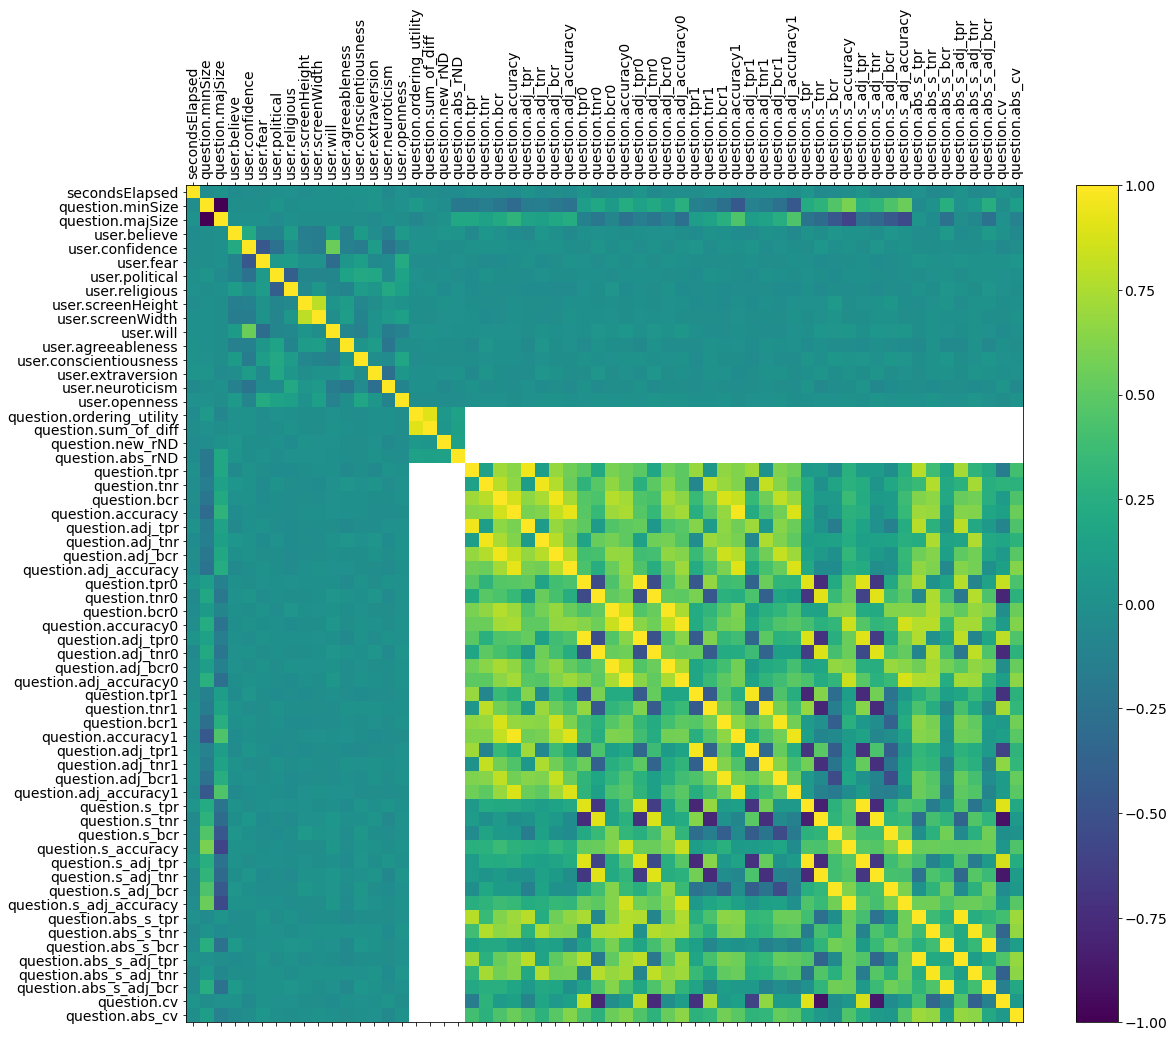

In [4]:
X_num = df[num_cols + num_cols_ran + num_cols_sel]
f = plt.figure(figsize=(19, 15))
plt.matshow(X_num.corr(), fignum=f.number) # TODO: should be spearman
plt.xticks(range(X_num.shape[1]), X_num.columns, fontsize=14, rotation=90)
plt.yticks(range(X_num.shape[1]), X_num.columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)

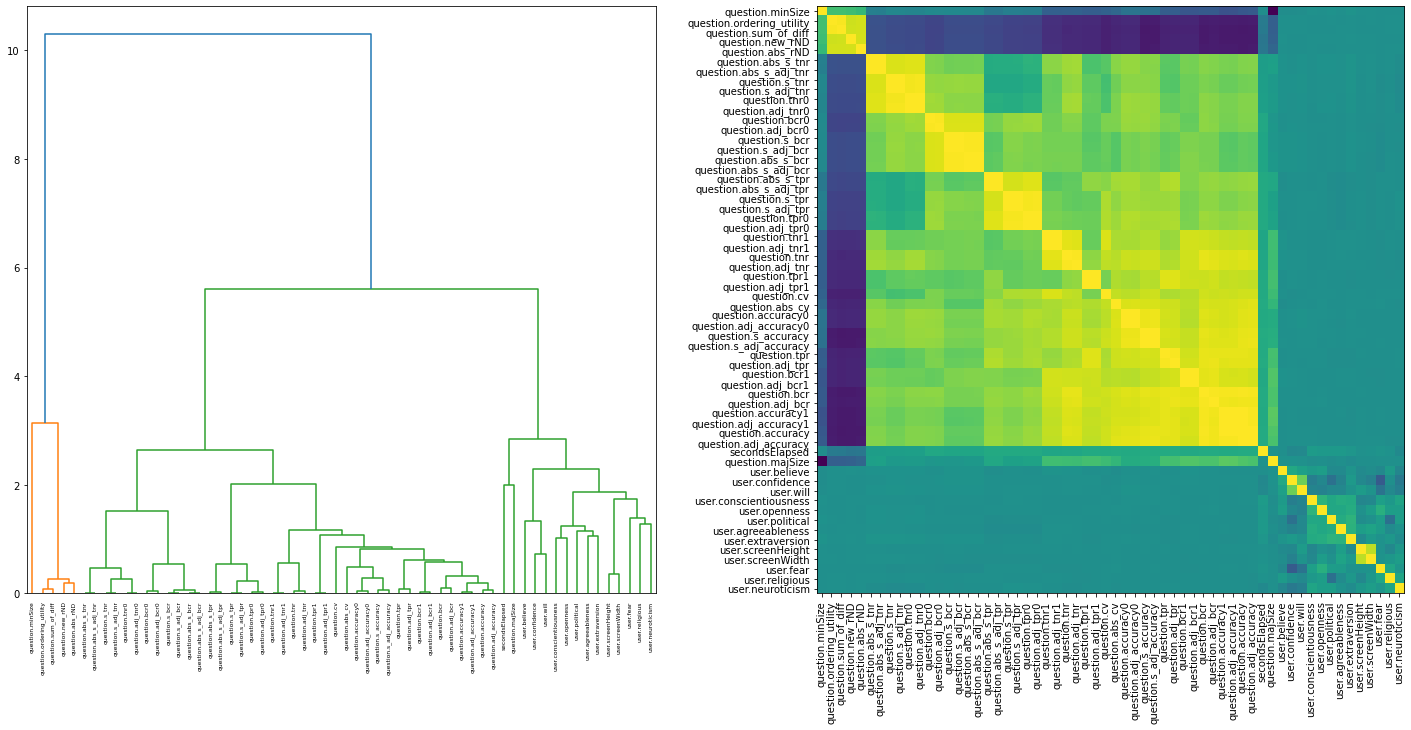

In [5]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
X2 = df
corr = spearmanr(np.nan_to_num(X2[num_cols + num_cols_ran + num_cols_sel]), axis=0).correlation
corr_linkage = hierarchy.complete(corr)
dendro = hierarchy.dendrogram(corr_linkage, ax=ax1,labels=list(X2[num_cols + num_cols_ran + num_cols_sel]),leaf_rotation=90)
dendro_idx = np.arange(0, len(dendro['ivl']))

ax2.imshow(corr[dendro['leaves'], :][:, dendro['leaves']])
ax2.set_xticks(dendro_idx)
ax2.set_yticks(dendro_idx)
ax2.set_xticklabels(dendro['ivl'], rotation='vertical')
ax2.set_yticklabels(dendro['ivl'])
fig.tight_layout()
plt.show()

In [6]:
# split for global model
y = df['rating']
est = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='uniform')
est.fit(y.to_numpy().reshape(-1, 1))
y = est.transform(y.to_numpy().reshape(-1, 1)).ravel()

rng = np.random.RandomState(seed=42)

X = df[num_cols + num_cols_ran + num_cols_sel + cat_cols]
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)

# build the global model
categorical_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])
numerical_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='mean'))
])

preprocessing = ColumnTransformer(
    [('cat', categorical_pipe, cat_cols),
     ('num', numerical_pipe, num_cols + num_cols_ran + num_cols_sel)])

rf = Pipeline([
    ('preprocess', preprocessing),
    ('classifier', RandomForestClassifier(n_jobs=-1, n_estimators=100))
])
rf.fit(X_train, y_train)
print("Global Model - RF train accuracy: %0.3f" % rf.score(X_train, y_train))
print("Global Model - RF test accuracy: %0.3f" % rf.score(X_test, y_test))

Global Model - RF train accuracy: 1.000
Global Model - RF test accuracy: 0.588


In [7]:
# split for selection model
y_sel = df_sel['rating']
est = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='uniform')
est.fit(y_sel.to_numpy().reshape(-1, 1))
y_sel = est.transform(y_sel.to_numpy().reshape(-1, 1)).ravel()
X_sel = df_sel.iloc[:,1:]

rng = np.random.RandomState(seed=42)

X_sel = X_sel[cat_cols + num_cols + num_cols_sel]
X_sel_train, X_sel_test, y_sel_train, y_sel_test = train_test_split(X_sel, y_sel, stratify=y_sel)

# build the selection model
categorical_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])
numerical_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='mean'))
])

preprocessing = ColumnTransformer(
    [('cat', categorical_pipe, cat_cols),
     ('num', numerical_pipe, num_cols + num_cols_sel)])

rf_sel = Pipeline([
    ('preprocess', preprocessing),
    ('classifier', RandomForestClassifier(n_jobs=-1, n_estimators=100))
])
rf_sel.fit(X_sel_train, y_sel_train)
print("Selection Model - RF train accuracy: %0.3f" % rf_sel.score(X_sel_train, y_sel_train))
print("Selection Model - RF test accuracy: %0.3f" % rf_sel.score(X_sel_test, y_sel_test))

Selection Model - RF train accuracy: 1.000
Selection Model - RF test accuracy: 0.572


In [8]:
# split for ranking model
y_ran = df_ran['rating']
est = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='uniform')
est.fit(y_ran.to_numpy().reshape(-1, 1))
y_ran = est.transform(y_ran.to_numpy().reshape(-1, 1)).ravel()
X_ran = df_ran.iloc[:,1:]

rng = np.random.RandomState(seed=42)

X_ran = X_ran[cat_cols + num_cols + num_cols_ran]
X_ran_train, X_ran_test, y_ran_train, y_ran_test = train_test_split(X_ran, y_ran, stratify=y_ran)

# build the ranking model
categorical_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])
numerical_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='mean'))
])

preprocessing = ColumnTransformer(
    [('cat', categorical_pipe, cat_cols),
     ('num', numerical_pipe, num_cols + num_cols_ran)])

rf_ran = Pipeline([
    ('preprocess', preprocessing),
    ('classifier', RandomForestClassifier(n_jobs=-1, n_estimators=100))
])
rf_ran.fit(X_ran_train, y_ran_train)
print("Ranking Model - RF train accuracy: %0.3f" % rf_ran.score(X_ran_train, y_ran_train))
print("Ranking Model - RF test accuracy: %0.3f" % rf_ran.score(X_ran_test, y_ran_test))

Ranking Model - RF train accuracy: 1.000
Ranking Model - RF test accuracy: 0.569


<ipython-input-9-3ead6fa9d031>:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(feature_names[sorted_idx])


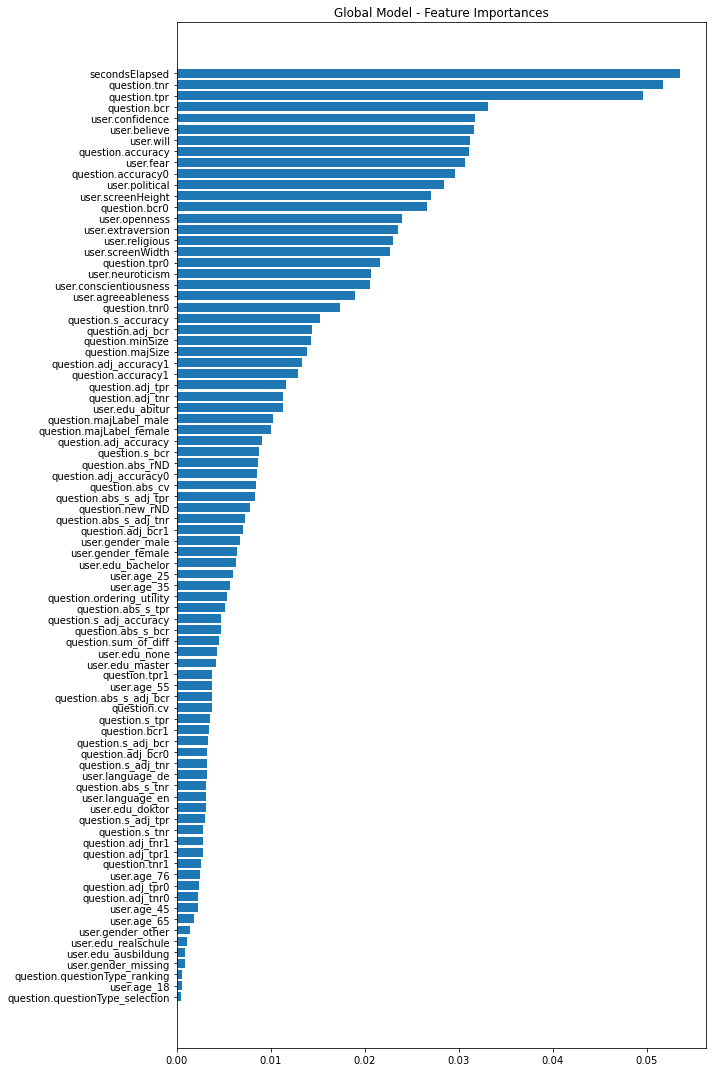

In [9]:
ohe = (rf.named_steps['preprocess']
         .named_transformers_['cat']
         .named_steps['onehot'])
feature_names = ohe.get_feature_names(input_features=cat_cols)
feature_names = np.r_[feature_names, num_cols + num_cols_sel + num_cols_ran] # num_cols

tree_feature_importances = (
    rf.named_steps['classifier'].feature_importances_)
sorted_idx = tree_feature_importances.argsort()

y_ticks = np.arange(0, len(feature_names))
fig, ax = plt.subplots(figsize=(10, 15))
ax.barh(y_ticks, tree_feature_importances[sorted_idx])
ax.set_yticklabels(feature_names[sorted_idx])
ax.set_yticks(y_ticks)
ax.set_title("Global Model - Feature Importances")
fig.tight_layout()
plt.show()

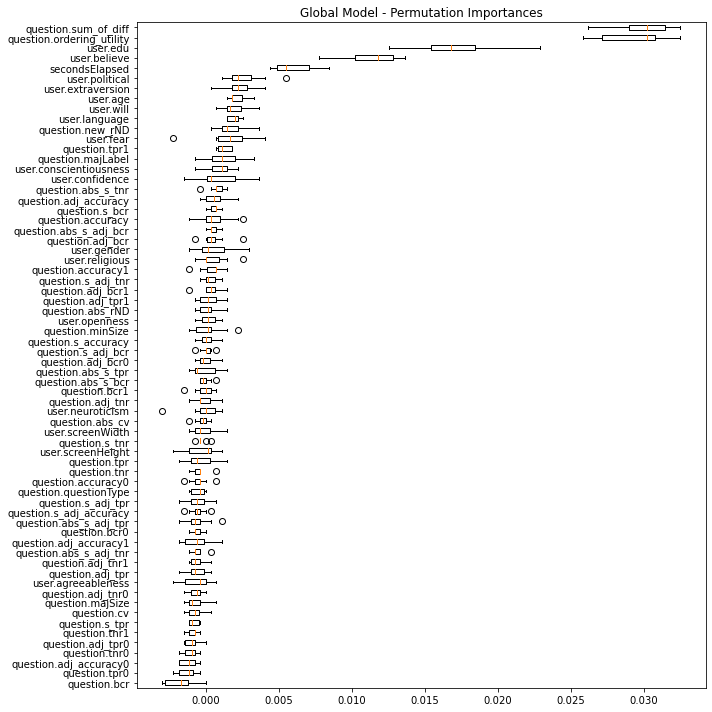

In [10]:
result = permutation_importance(rf, X, y, n_repeats=10, n_jobs=-1)
sorted_idx = result.importances_mean.argsort()

fig, ax = plt.subplots(figsize=(10, 10))
ax.boxplot(result.importances[sorted_idx].T, vert=False, labels=X.columns[sorted_idx])
ax.set_title("Global Model - Permutation Importances")
fig.tight_layout()
plt.show()

<ipython-input-11-1812c2bbf7df>:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(feature_names[sorted_idx])


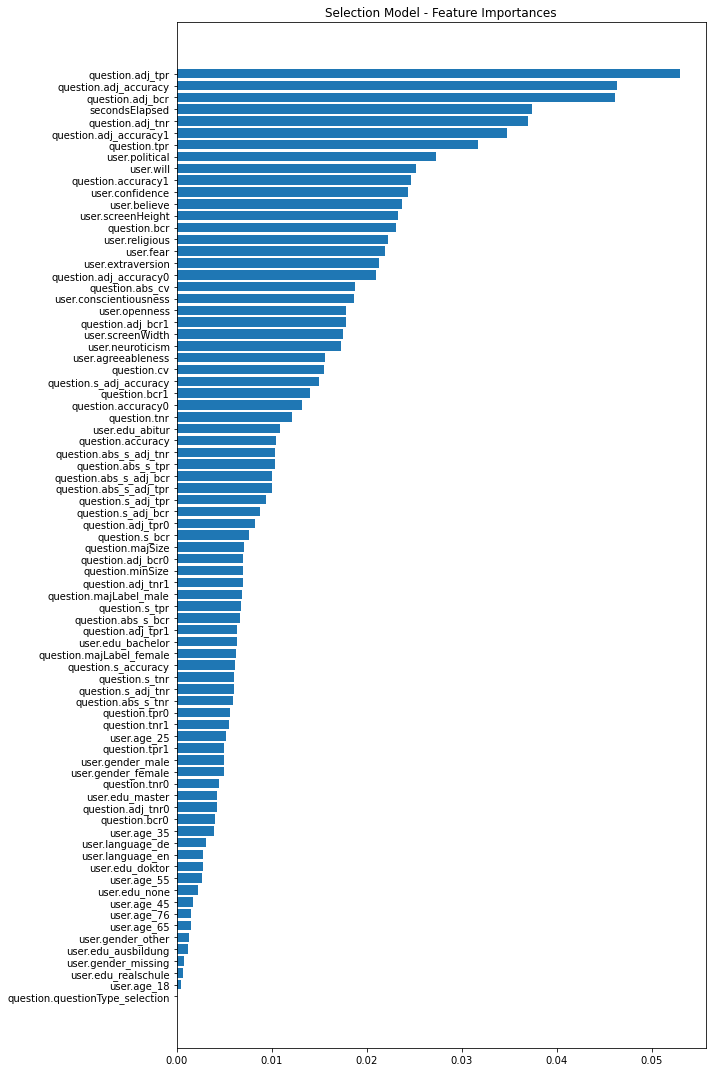

In [11]:
ohe = (rf_sel.named_steps['preprocess']
         .named_transformers_['cat']
         .named_steps['onehot'])
feature_names = ohe.get_feature_names(input_features=cat_cols)
feature_names = np.r_[feature_names, num_cols + num_cols_sel] # num_cols

tree_feature_importances = (
    rf_sel.named_steps['classifier'].feature_importances_)
sorted_idx = tree_feature_importances.argsort()

y_ticks = np.arange(0, len(feature_names))
fig, ax = plt.subplots(figsize=(10, 15))
ax.barh(y_ticks, tree_feature_importances[sorted_idx])
ax.set_yticklabels(feature_names[sorted_idx])
ax.set_yticks(y_ticks)
ax.set_title("Selection Model - Feature Importances")
fig.tight_layout()
plt.show()

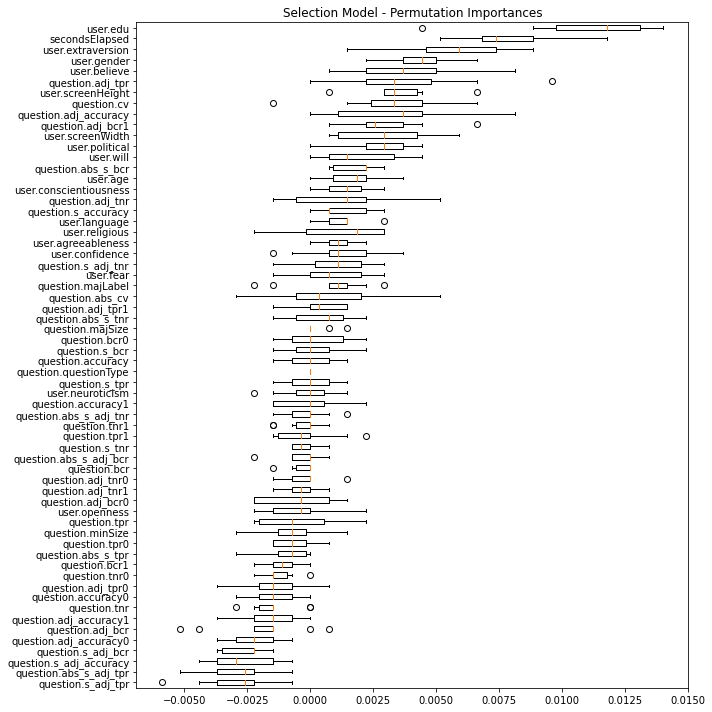

In [12]:
result = permutation_importance(rf_sel, X_sel, y_sel, n_repeats=10, n_jobs=-1)
sorted_idx = result.importances_mean.argsort()

fig, ax = plt.subplots(figsize=(10, 10))
ax.boxplot(result.importances[sorted_idx].T, vert=False, labels=X_sel.columns[sorted_idx])
ax.set_title("Selection Model - Permutation Importances")
fig.tight_layout()
plt.show()

<ipython-input-13-c49b066b3360>:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(feature_names[sorted_idx])


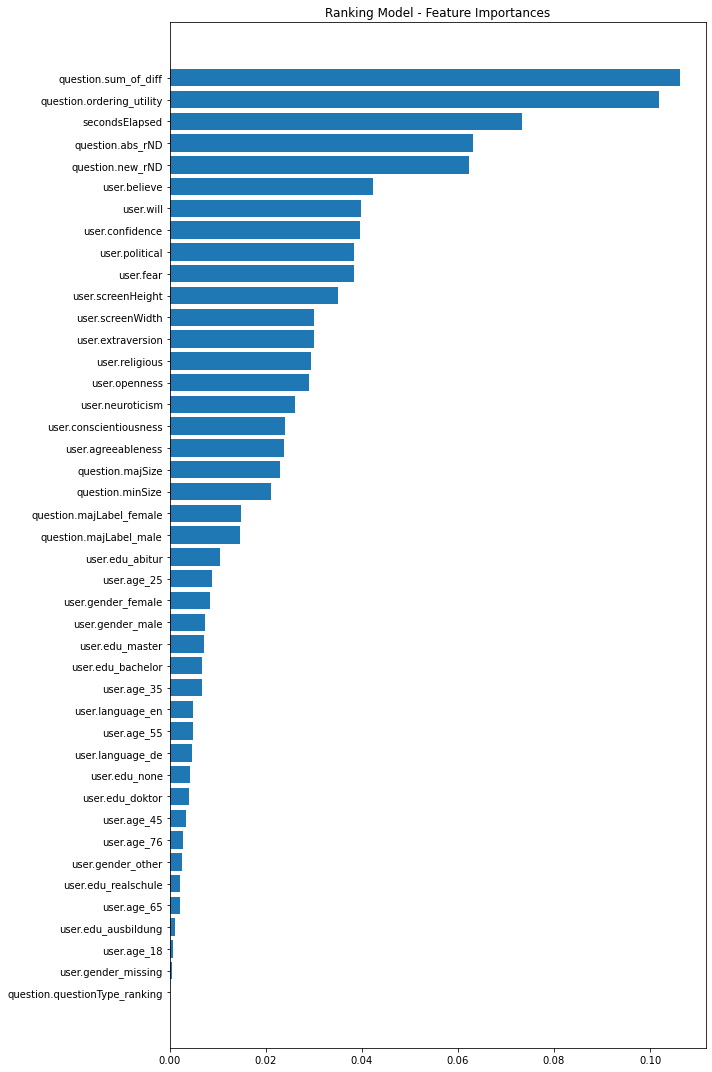

In [13]:
ohe = (rf_ran.named_steps['preprocess']
         .named_transformers_['cat']
         .named_steps['onehot'])
feature_names = ohe.get_feature_names(input_features=cat_cols)
feature_names = np.r_[feature_names, num_cols + num_cols_ran] # num_cols

tree_feature_importances = (
    rf_ran.named_steps['classifier'].feature_importances_)
sorted_idx = tree_feature_importances.argsort()

y_ticks = np.arange(0, len(feature_names))
fig, ax = plt.subplots(figsize=(10, 15))
ax.barh(y_ticks, tree_feature_importances[sorted_idx])
ax.set_yticklabels(feature_names[sorted_idx])
ax.set_yticks(y_ticks)
ax.set_title("Ranking Model - Feature Importances")
fig.tight_layout()
plt.show()

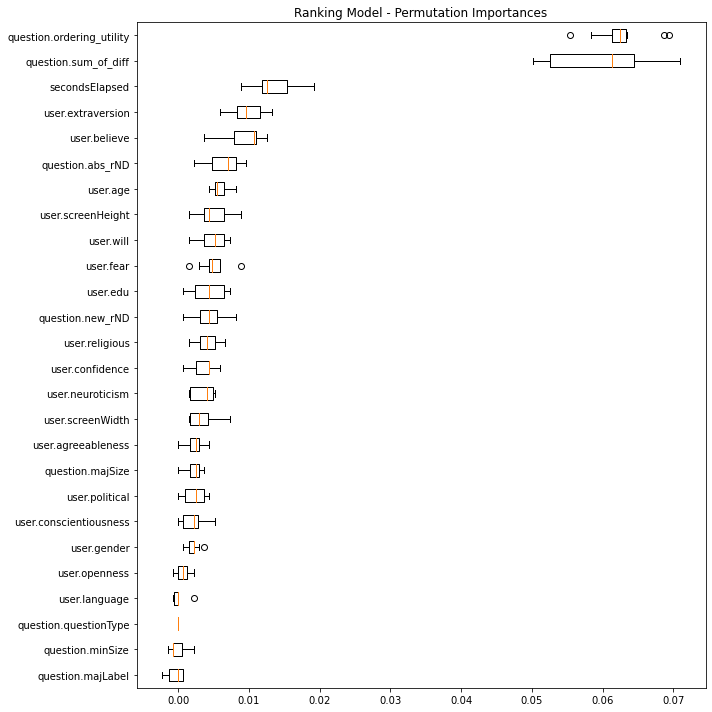

In [14]:
result = permutation_importance(rf_ran, X_ran, y_ran, n_repeats=10, n_jobs=-1)
sorted_idx = result.importances_mean.argsort()

fig, ax = plt.subplots(figsize=(10, 10))
ax.boxplot(result.importances[sorted_idx].T, vert=False, labels=X_ran.columns[sorted_idx])
ax.set_title("Ranking Model - Permutation Importances")
fig.tight_layout()
plt.show()

In [15]:
# split for minimal selection model
y_sel = df_sel['rating']
est = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='uniform')
est.fit(y_sel.to_numpy().reshape(-1, 1))
y_sel = est.transform(y_sel.to_numpy().reshape(-1, 1)).ravel()
X_sel_min = df_sel.iloc[:,1:]

rng = np.random.RandomState(seed=42)

num_cols_sel_min = [
    #'user.confidence',
    'user.political',
    'user.extraversion',
    'user.openness',
    'question.adj_tpr',
    'question.abs_s_adj_tpr',
    'question.abs_cv'
]

cat_cols_sel_min = [
    'user.age',
    'user.edu',
    'user.gender',
]

X_sel_min = X_sel_min[cat_cols_sel_min + num_cols_sel_min]
X_sel_min_train, X_sel_min_test, y_sel_train, y_sel_test = train_test_split(X_sel_min, y_sel, stratify=y_sel)

# build the minimal selection model
categorical_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])
numerical_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='mean'))
])

preprocessing = ColumnTransformer(
    [('cat', categorical_pipe, cat_cols_sel_min),
     ('num', numerical_pipe, num_cols_sel_min)])

rf_sel_min = Pipeline([
    ('preprocess', preprocessing),
    ('classifier', RandomForestClassifier(n_jobs=-1, n_estimators=100))
])
rf_sel_min.fit(X_sel_min_train, y_sel_train)
print("Minimal Selection Model - RF train accuracy: %0.3f" % rf_sel_min.score(X_sel_min_train, y_sel_train))
print("Minimal Selection Model - RF test accuracy: %0.3f" % rf_sel_min.score(X_sel_min_test, y_sel_test))

Minimal Selection Model - RF train accuracy: 0.999
Minimal Selection Model - RF test accuracy: 0.593


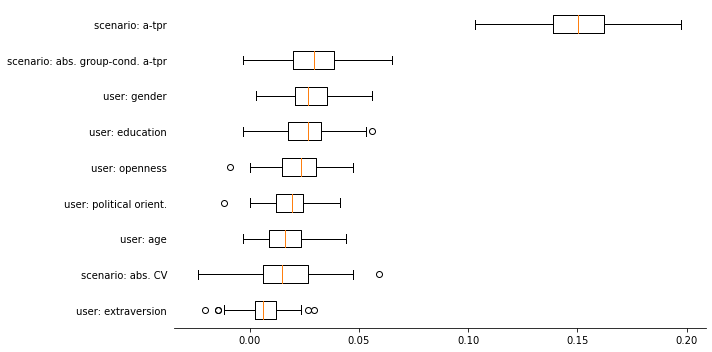

In [16]:
result = permutation_importance(rf_sel_min, X_sel_min_test, y_sel_test, n_repeats=100, n_jobs=-1)
sorted_idx = result.importances_mean.argsort()
labels = np.array([
    'user: age',
    'user: education',
    'user: gender',
    'user: political orient.',
    'user: extraversion',
    'user: openness',
    'scenario: a-tpr',
    'scenario: abs. group-cond. a-tpr',
    'scenario: abs. CV'
])


fig, ax = plt.subplots(figsize=(10, 5))
ax.boxplot(result.importances[sorted_idx].T, vert=False, labels=labels[sorted_idx])
fig.tight_layout()
sns.despine(left=True)
plt.tick_params(left=False)
plt.show()

In [17]:
# split for minimal ranking model
y_ran = df_ran['rating']
est = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='uniform')
est.fit(y_ran.to_numpy().reshape(-1, 1))
y_ran = est.transform(y_ran.to_numpy().reshape(-1, 1)).ravel()
X_ran_min = df_ran.iloc[:,1:]

rng = np.random.RandomState(seed=42)

num_cols_ran_min = [
    #'user.confidence',
    'user.political',
    'user.extraversion',
    'user.openness',
    'question.ordering_utility',
    'question.abs_rND',
]

cat_cols_ran_min = [
    'user.age',
    'user.edu',
    'user.gender',
]

X_ran_min = X_ran_min[cat_cols_ran_min + num_cols_ran_min]
X_ran_min_train, X_ran_min_test, y_ran_train, y_ran_test = train_test_split(X_ran_min, y_ran, stratify=y_ran)

# build the minimal selection model
categorical_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])
numerical_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='mean'))
])

preprocessing = ColumnTransformer(
    [('cat', categorical_pipe, cat_cols_ran_min),
     ('num', numerical_pipe, num_cols_ran_min)])

rf_ran_min = Pipeline([
    ('preprocess', preprocessing),
    ('classifier', RandomForestClassifier(n_jobs=-1, n_estimators=100))
])
rf_ran_min.fit(X_ran_min_train, y_ran_train)
print("Minimal Ranking Model - RF train accuracy: %0.3f" % rf_ran_min.score(X_ran_min_train, y_ran_train))
print("Minimal Ranking Model - RF test accuracy: %0.3f" % rf_ran_min.score(X_ran_min_test, y_ran_test))

Minimal Ranking Model - RF train accuracy: 1.000
Minimal Ranking Model - RF test accuracy: 0.534


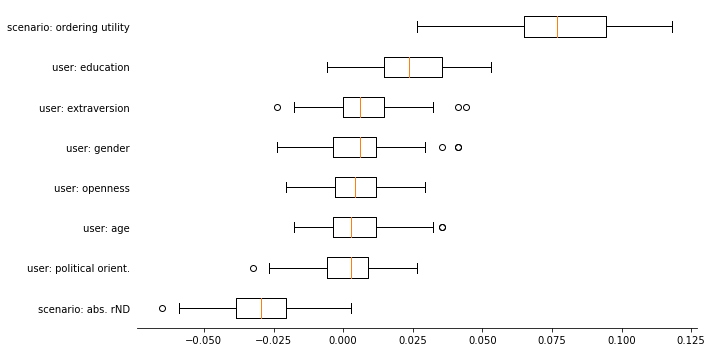

In [18]:
result = permutation_importance(rf_ran_min, X_ran_min_test, y_ran_test, n_repeats=100, n_jobs=-1)
sorted_idx = result.importances_mean.argsort()
labels = np.array([
    'user: age',
    'user: education',
    'user: gender',
    'user: political orient.',
    'user: extraversion',
    'user: openness',
    'scenario: ordering utility',
    'scenario: abs. rND'
])

fig, ax = plt.subplots(figsize=(10, 5))
ax.boxplot(result.importances[sorted_idx].T, vert=False, labels=labels[sorted_idx])
fig.tight_layout()
sns.despine(left=True)
plt.tick_params(left=False)
plt.show()

In [19]:
cat_cols_no_demographics = [
    'question.majLabel',
    'question.questionType',
]
num_cols_no_demographics = [
    'secondsElapsed',
    'question.minSize',
    'question.majSize',
]

def init_pipeline(_cat_cols, _num_cols):
    categorical_pipe = Pipeline([
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])
    numerical_pipe = Pipeline([
        ('imputer', SimpleImputer(strategy='mean'))
    ])

    preprocessing = ColumnTransformer(
        [('cat', categorical_pipe, _cat_cols),
         ('num', numerical_pipe, _num_cols)])

    rf = Pipeline([
        ('preprocess', preprocessing),
        ('classifier', RandomForestClassifier(n_jobs=-1, n_estimators=100))
    ])
    return rf

def global_model(n_bins, strategy, cv):
    y = df['rating']
    est = KBinsDiscretizer(n_bins=n_bins, encode='ordinal', strategy=strategy)
    est.fit(y.to_numpy().reshape(-1, 1))
    y = est.transform(y.to_numpy().reshape(-1, 1)).ravel()
    
    X = df[num_cols + num_cols_ran + num_cols_sel + cat_cols]
    
    rf = init_pipeline(cat_cols, num_cols + num_cols_ran + num_cols_sel)
    return (cross_val_score(rf, X, y, cv=cv))

def selection_model(n_bins, strategy, cv):
    y_sel = df_sel['rating']
    est = KBinsDiscretizer(n_bins=n_bins, encode='ordinal', strategy=strategy)
    est.fit(y_sel.to_numpy().reshape(-1, 1))
    y_sel = est.transform(y_sel.to_numpy().reshape(-1, 1)).ravel()
    X_sel = df_sel.iloc[:,1:][cat_cols + num_cols + num_cols_sel]
    
    rf_sel = init_pipeline(cat_cols, num_cols + num_cols_sel)
    return (cross_val_score(rf_sel, X_sel, y_sel, cv=cv))

def ranking_model(n_bins, strategy, cv):
    y_ran = df_ran['rating']
    est = KBinsDiscretizer(n_bins=n_bins, encode='ordinal', strategy=strategy)
    est.fit(y_ran.to_numpy().reshape(-1, 1))
    y_ran = est.transform(y_ran.to_numpy().reshape(-1, 1)).ravel()
    X_ran = df_ran.iloc[:,1:][cat_cols + num_cols + num_cols_ran]

    rf_ran = init_pipeline(cat_cols, num_cols + num_cols_ran)
    return (cross_val_score(rf_ran, X_ran, y_ran, cv=cv))

def selection_model_min(n_bins, strategy, cv):
    y_sel = df_sel['rating']
    est = KBinsDiscretizer(n_bins=n_bins, encode='ordinal', strategy=strategy)
    est.fit(y_sel.to_numpy().reshape(-1, 1))
    y_sel = est.transform(y_sel.to_numpy().reshape(-1, 1)).ravel()
    X_sel = df_sel.iloc[:,1:][cat_cols_sel_min + num_cols_sel_min]
    
    rf_sel_min = init_pipeline(cat_cols_sel_min, num_cols_sel_min)
    return (cross_val_score(rf_sel_min, X_sel, y_sel, cv=cv))

def ranking_model_min(n_bins, strategy, cv):
    y_ran = df_ran['rating']
    est = KBinsDiscretizer(n_bins=n_bins, encode='ordinal', strategy=strategy)
    est.fit(y_ran.to_numpy().reshape(-1, 1))
    y_ran = est.transform(y_ran.to_numpy().reshape(-1, 1)).ravel()
    X_ran = df_ran.iloc[:,1:][cat_cols_ran_min + num_cols_ran_min]

    rf_ran_min = init_pipeline(cat_cols_ran_min, num_cols_ran_min)
    return (cross_val_score(rf_ran_min, X_ran, y_ran, cv=cv))

def global_model_no_demographics(n_bins, strategy, cv):
    y = df['rating']
    est = KBinsDiscretizer(n_bins=n_bins, encode='ordinal', strategy=strategy)
    est.fit(y.to_numpy().reshape(-1, 1))
    y = est.transform(y.to_numpy().reshape(-1, 1)).ravel()
    X = df.iloc[:,1:][num_cols_no_demographics + num_cols_ran + num_cols_sel + cat_cols_no_demographics]

    rf = init_pipeline(cat_cols_no_demographics, num_cols_ran + num_cols_sel + num_cols_no_demographics)
    return (cross_val_score(rf, X, y, cv=cv))

def selection_model_no_demographics(n_bins, strategy, cv):
    y_sel = df_sel['rating']
    est = KBinsDiscretizer(n_bins=n_bins, encode='ordinal', strategy=strategy)
    est.fit(y_sel.to_numpy().reshape(-1, 1))
    y_sel = est.transform(y_sel.to_numpy().reshape(-1, 1)).ravel()
    X_sel = df_sel.iloc[:,1:][num_cols_no_demographics + num_cols_sel + cat_cols_no_demographics]
    
    rf_sel_min = init_pipeline(cat_cols_no_demographics, num_cols_no_demographics + num_cols_sel)
    return (cross_val_score(rf_sel_min, X_sel, y_sel, cv=cv))

def ranking_model_no_demographics(n_bins, strategy, cv):
    y_ran = df_ran['rating']
    est = KBinsDiscretizer(n_bins=n_bins, encode='ordinal', strategy=strategy)
    est.fit(y_ran.to_numpy().reshape(-1, 1))
    y_ran = est.transform(y_ran.to_numpy().reshape(-1, 1)).ravel()
    X_ran = df_ran.iloc[:,1:][num_cols_no_demographics + num_cols_ran + cat_cols_no_demographics]

    rf_ran_min = init_pipeline(cat_cols_no_demographics, num_cols_no_demographics + num_cols_ran)
    return (cross_val_score(rf_ran_min, X_ran, y_ran, cv=cv))

In [49]:
import warnings

strategies=['uniform','quantile','kmeans']
cv = 10

df_results = pd.DataFrame(columns=['model type', 'binning strategy', 'n_bins', 'cv_score'])


with warnings.catch_warnings(): #catch warnings concerning too narrow bins
    warnings.simplefilter("error")
    for k in range(len(strategies)):
        for i in range(2,10):
            try:
                scores = global_model(n_bins=i, strategy=strategies[k], cv=cv)
            except Warning as w:
                print(strategies[k], i, ':', w)
            else:
                for j in range(len(scores)):
                    new_row = {'model type': 'global full', 'binning strategy': strategies[k], 'n_bins': i, 'cv_score': scores[j]}
                    df_results = df_results.append(new_row, ignore_index=True)
            try:
                scores = selection_model(n_bins=i, strategy=strategies[k], cv=cv)
            except Warning as w:
                print(strategies[k], i, ':', w)
            else:
                for j in range(len(scores)):
                    new_row = {'model type': 'selection full', 'binning strategy': strategies[k], 'n_bins': i, 'cv_score': scores[j]}
                    df_results = df_results.append(new_row, ignore_index=True)
            try:
                scores = ranking_model(n_bins=i, strategy=strategies[k], cv=cv)
            except Warning as w:
                print(strategies[k], i, ':', w)
            else:
                for j in range(len(scores)):
                    new_row = {'model type': 'ranking full', 'binning strategy': strategies[k], 'n_bins': i, 'cv_score': scores[j]}
                    df_results = df_results.append(new_row, ignore_index=True)
            try:
                scores = selection_model_min(n_bins=i, strategy=strategies[k], cv=cv)
            except Warning as w:
                print(strategies[k], i, ':', w)
            else:
                for j in range(len(scores)):
                    new_row = {'model type': 'selection minimal', 'binning strategy': strategies[k], 'n_bins': i, 'cv_score': scores[j]}
                    df_results = df_results.append(new_row, ignore_index=True)
            try:
                scores = ranking_model_min(n_bins=i, strategy=strategies[k], cv=cv)
            except Warning as w:
                print(strategies[k], i, ':', w)
            else:
                for j in range(len(scores)):
                    new_row = {'model type': 'ranking minimal', 'binning strategy': strategies[k], 'n_bins': i, 'cv_score': scores[j]}
                    df_results = df_results.append(new_row, ignore_index=True)
            try:
                scores = global_model_no_demographics(n_bins=i, strategy=strategies[k], cv=cv)
            except Warning as w:
                print(strategies[k], i, ':', w)
            else:
                for j in range(len(scores)):
                    new_row = {'model type': 'global no demographics', 'binning strategy': strategies[k], 'n_bins': i, 'cv_score': scores[j]}
                    df_results = df_results.append(new_row, ignore_index=True)
            
            try:
                scores = selection_model_no_demographics(n_bins=i, strategy=strategies[k], cv=cv)
            except Warning as w:
                print(strategies[k], i, ':', w)
            else:
                for j in range(len(scores)):
                    new_row = {'model type': 'selection no demographics', 'binning strategy': strategies[k], 'n_bins': i, 'cv_score': scores[j]}
                    df_results = df_results.append(new_row, ignore_index=True)
            try:
                scores = ranking_model_no_demographics(n_bins=i, strategy=strategies[k], cv=cv)
            except Warning as w:
                print(strategies[k], i, ':', w)
            else:
                for j in range(len(scores)):
                    new_row = {'model type': 'ranking no demographics', 'binning strategy': strategies[k], 'n_bins': i, 'cv_score': scores[j]}
                    df_results = df_results.append(new_row, ignore_index=True)

quantile 5 : Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
quantile 5 : Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
quantile 5 : Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
quantile 5 : Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
quantile 5 : Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
quantile 6 : Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
quantile 6 : Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
quantile 6 : Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number o

[(0.0, 0.85)]

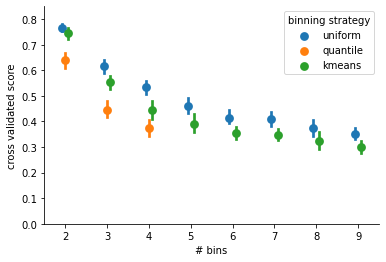

In [59]:
ax = sns.pointplot(data=df_results.query("`model type` == 'global full'"), dodge=.15,
                  x='n_bins', y='cv_score', hue='binning strategy', estimator=np.mean, join=False)
sns.despine()
ax.set(xlabel='# bins', ylabel='cross validated score')
ax.set(ylim=(0, 0.85))
#ax.set_title('Global Model with all Attributes')

[(0.0, 0.85)]

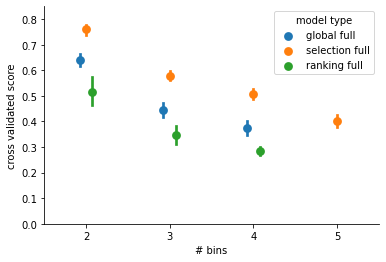

In [60]:
df_results_full = df_results[df_results['model type'].str.contains('full')]
ax = sns.pointplot(data=df_results_full[df_results_full['binning strategy'] == 'quantile'], dodge=.15,
                  x='n_bins', y='cv_score', hue='model type', estimator=np.mean, join=False, ci=90)
sns.despine()
ax.set(xlabel='# bins', ylabel='cross validated score')
ax.set(ylim=(0, 0.85))
#g.set_title('Models with all Attributes and Uniform Binning')

[(0.0, 0.85)]

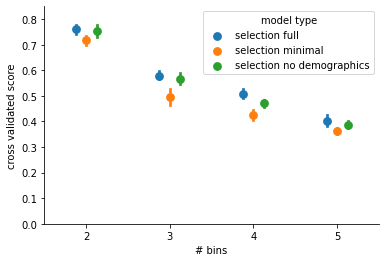

In [61]:
df_results_sel = df_results[df_results['model type'].str.contains('selection')]
ax = sns.pointplot(data=df_results_sel[df_results_sel['binning strategy'] == 'quantile'], dodge=.25,
                  x='n_bins', y='cv_score', hue='model type', estimator=np.mean, join=False, ci=90)
sns.despine()
ax.set(xlabel='# bins', ylabel='cross validated score')
ax.set(ylim=(0, 0.85))
#g.set_title('Selection Models with Uniform Binning')

**Demographics** add crucial information that helps with more detailed models (higher n_bins)

[(0.0, 0.85)]

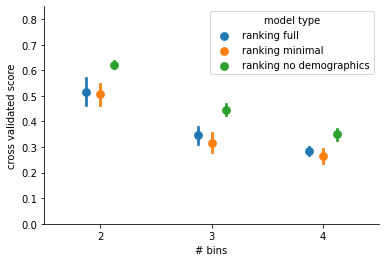

In [62]:
df_results_ran = df_results[df_results['model type'].str.contains('ranking')]
ax = sns.pointplot(data=df_results_ran[df_results_ran['binning strategy'] == 'quantile'], dodge=.25,
                  x='n_bins', y='cv_score', hue='model type', estimator=np.mean, join=False, ci=90)
sns.despine()
ax.set(xlabel='# bins', ylabel='cross validated score')
ax.set(ylim=(0, 0.85))
#g.set_title('Ranking Models with Uniform Binning')

**Demographics** seem to have a negative effect on accuracy?!